In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [15]:
df = pd.read_csv("zillow_rent_cleaned.csv")

# Convert Date column to datetime
df["Date"] = pd.to_datetime(df["Date"], errors="coerce")

# Extract Year and Month
df["Year"] = df["Date"].dt.year
df["Month"] = df["Date"].dt.month

# Sort for proper lag creation
df = df.sort_values(["City", "Metro", "Year", "Month"]).reset_index(drop=True)

# ============================================
# 2. Create Features (Lag + Rolling + Seasonal)
# ============================================

# Lag features
df["rent_lag_1"]  = df.groupby("City")["RentPrice"].shift(1)
df["rent_lag_12"] = df.groupby("City")["RentPrice"].shift(12)

# Cyclical month encoding
df["Month_sin"] = np.sin(2 * np.pi * df["Month"] / 12)
df["Month_cos"] = np.cos(2 * np.pi * df["Month"] / 12)

# Rolling averages
df["ma_3"] = df.groupby("City")["RentPrice"].rolling(3).mean().reset_index(0, drop=True)
df["ma_6"] = df.groupby("City")["RentPrice"].rolling(6).mean().reset_index(0, drop=True)

# Drop rows with missing values due to lag/rolling
df_model = df.dropna().reset_index(drop=True)

/var/folders/ky/xqwppm3x1mbb4h8dcfjwqx740000gn/T/ipykernel_37628/3146205905.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["Date"] = pd.to_datetime(df["Date"], errors="coerce")


In [16]:
X = df_model[["City","State","Metro","Population Rank","Year","Month",
        "rent_lag_1","rent_lag_12","ma_3","ma_6","Month_sin","Month_cos"]]
y = df_model['RentPrice']


In [17]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)


In [19]:
numeric_features = ['Year', 'Month', 'Population Rank', "rent_lag_1","rent_lag_12","ma_3","ma_6","Month_sin","Month_cos"]
categorical_features = ['State', 'Metro']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

linreg_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LinearRegression())
])

In [20]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

linreg_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LinearRegression())
])


In [21]:
linreg_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', 'passthrough',
                                                  ['Year', 'Month',
                                                   'Population Rank',
                                                   'rent_lag_1', 'rent_lag_12',
                                                   'ma_3', 'ma_6', 'Month_sin',
                                                   'Month_cos']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['State', 'Metro'])])),
                ('model', LinearRegression())])

In [22]:
y_pred = linreg_pipeline.predict(X_test)

print("Linear Regression Results")
print("MAE :", mean_absolute_error(y_test, y_pred))
print("RMSE:", mean_squared_error(y_test, y_pred, squared=False))
print("R²  :", r2_score(y_test, y_pred))


Linear Regression Results
MAE : 12.06408844708636
RMSE: 40.8110117685409
R²  : 0.9961966716122935


In [79]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

In [80]:
X_sub = X_train[:10000]  
y_sub = y_train[:10000]

rf = RandomForestRegressor(
    random_state=42,
    n_jobs=1
)

rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),  # ColumnTransformer
    ('model', rf)
])

param_grid_rf = {
    'model__n_estimators': [50, 100],
    'model__max_depth': [10, 20, None],
    'model__min_samples_split': [2, 5]
}

rf_search = RandomizedSearchCV(
    rf_pipeline,
    param_distributions=param_grid_rf,
    n_iter=5,
    cv=2,
    scoring='neg_mean_absolute_error',
    n_jobs=1,
    random_state=42
)


In [82]:
# rf_search.fit(X_sub, y_sub)

In [12]:
y_pred_rf = rf_search.predict(X_test)

In [13]:
y_pred_rf

array([1197.22,  835.34,  969.56, ..., 1203.62, 1199.54, 1201.17])

In [14]:
print("Random Forest")
print("MAE:", mean_absolute_error(y_test, y_pred_rf))
print("RMSE:", mean_squared_error(y_test, y_pred_rf, squared=False))
print("R²:", r2_score(y_test, y_pred_rf))

Random Forest
MAE: 346.7995532249566
RMSE: 594.8993957581935
R²: 0.1811039366453241


In [15]:
# Gradient Boosting Regressor

from sklearn.ensemble import GradientBoostingRegressor

In [16]:
from sklearn.model_selection import GridSearchCV

gbr = GradientBoostingRegressor(random_state=42)

gbr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),  # ColumnTransformer with OHE
    ('model', gbr)
])

param_grid_gbr = {
    'model__n_estimators': [30, 50],
    'model__learning_rate': [0.1],
    'model__max_depth': [3]
}

gbr_search = GridSearchCV(
    gbr_pipeline,
    param_grid=param_grid_gbr,  # GridSearch automatically tries all combinations
    cv=2,
    scoring='neg_mean_absolute_error',
    n_jobs=-1
)

gbr_search.fit(X_train, y_train)

GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         'passthrough',
                                                                         ['Year',
                                                                          'Month',
                                                                          'Population '
                                                                          'Rank']),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['State',
                                                                          'Metro'])])),
                                       ('model',
                                        GradientBoostingRegressor(random_state=42))]),
             n_jobs=-1,
             param_grid={'model__learning_rate': [0.1], 'model__max_depth': [3],
                         'model__n_estimators': [30, 50]},
             scoring='neg_mean_absolute_error')

In [17]:
y_pred_gbr = gbr_search.predict(X_test)

In [18]:
y_pred_gbr

array([1144.72756452, 1250.30665299, 1250.30665299, ..., 1265.07569373,
       1265.07569373, 1265.07569373])

In [19]:
print("Gradient Boosting")
print("MAE:", mean_absolute_error(y_test, y_pred_gbr))
print("RMSE:", mean_squared_error(y_test, y_pred_gbr, squared=False))
print("R²:", r2_score(y_test, y_pred_gbr))

Gradient Boosting
MAE: 300.146920710817
RMSE: 541.8231780559732
R²: 0.3207073956504939


In [20]:
# Find the latest Year and Month in your dataset
last_year = df_model['Year'].max()
last_month = df_model[df_model['Year'] == last_year]['Month'].max()

# Initialize
future_years = []
future_months = []

year, month = last_year, last_month

# Forecast next 12 months
for _ in range(12):
    month += 1
    if month > 12:
        month = 1
        year += 1
    future_years.append(year)
    future_months.append(month)

In [24]:
# ============================================================
# Generate forecasts for ALL city–metro combinations
# ============================================================

# To store results for all cities/metros
all_future_rows = []

# Get unique combinations
city_metro_pairs = df_model[['City', 'Metro']].drop_duplicates()

for _, pair in city_metro_pairs.iterrows():

    sel_city = pair["City"]
    sel_metro = pair["Metro"]

    # --------------------------------------------
    # 1. Extract historical data for this city+metro
    # --------------------------------------------
    hist = df_model[
        (df_model["City"] == sel_city) &
        (df_model["Metro"] == sel_metro)
    ].sort_values(["Year", "Month"]).copy()

    if len(hist) < 12:
        continue  # skip insufficient history

    state = hist["State"].iloc[-1]
    pop_rank = hist["Population Rank"].iloc[-1]

    last_year = hist["Year"].iloc[-1]
    last_month = hist["Month"].iloc[-1]

    # --------------------------------------------
    # 2. Build next 12 months
    # --------------------------------------------
    future_years = []
    future_months = []

    for i in range(1, 13):
        m = last_month + i
        y = last_year + (m - 1) // 12
        m = ((m - 1) % 12) + 1
        future_years.append(y)
        future_months.append(m)

    # --------------------------------------------
    # 3. Initialize lag + rolling features
    # --------------------------------------------
    lag_1 = hist["RentPrice"].iloc[-1]
    lag_12 = hist["RentPrice"].iloc[-12]

    rolling_history = list(hist["RentPrice"].iloc[-6:])
    last_ma3 = hist["ma_3"].iloc[-1]
    last_ma6 = hist["ma_6"].iloc[-1]

    # --------------------------------------------
    # 4. Build future rows (pre-prediction)
    # --------------------------------------------
    future_rows = []

    for y, m in zip(future_years, future_months):

        month_sin = np.sin(2 * np.pi * m / 12)
        month_cos = np.cos(2 * np.pi * m / 12)

        future_rows.append({
            "City": sel_city,
            "Metro": sel_metro,
            "State": state,
            "Population Rank": pop_rank,
            "Year": y,
            "Month": m,
            "rent_lag_1": lag_1,
            "rent_lag_12": lag_12,
            "Month_sin": month_sin,
            "Month_cos": month_cos,
            "ma_3": last_ma3,
            "ma_6": last_ma6
        })

    future_df = pd.DataFrame(future_rows)

    # --------------------------------------------
    # 5. Iterative predictions
    # --------------------------------------------
    preds = []

    for i in range(len(future_df)):

        row = future_df.iloc[[i]].copy()
        pred = linreg_pipeline.predict(row)[0]
        preds.append(pred)

        # Update rolling history → rolling averages
        rolling_history.append(pred)
        ma3_new = np.mean(rolling_history[-3:])
        ma6_new = np.mean(rolling_history[-6:])

        future_df.loc[future_df.index[i], "ma_3"] = ma3_new
        future_df.loc[future_df.index[i], "ma_6"] = ma6_new

        # Update lag_1 and lag_12
        if i + 1 < len(future_df):
            future_df.loc[future_df.index[i + 1], "rent_lag_1"] = pred
            future_df.loc[future_df.index[i + 1], "rent_lag_12"] = (
                rolling_history[-12] if len(rolling_history) >= 12 else rolling_history[0]
            )

    future_df["Predicted_Rent"] = preds

    # Add dates
    future_df["Date"] = pd.to_datetime(dict(
        year=future_df["Year"],
        month=future_df["Month"],
        day=1
    ))

    # Append to global list
    all_future_rows.append(future_df)

# --------------------------------------------
# 6. Combine all forecasts into one DataFrame
# --------------------------------------------
future_df_all = pd.concat(all_future_rows, ignore_index=True)

future_df_all.head()


,City,Metro,State,Population Rank,Year,Month,rent_lag_1,rent_lag_12,Month_sin,Month_cos,ma_3,ma_6,Predicted_Rent,Date
0,Abbeville,Dothan,AL,5970,2017,2,921.000000,970.0,8.660254e-01,5.000000e-01,925.015186,921.674260,929.045559,2017-02-01
1,Abbeville,Dothan,AL,5970,2017,3,929.045559,915.0,1.000000e+00,6.123234e-17,924.562599,923.281299,923.642238,2017-03-01
2,Abbeville,Dothan,AL,5970,2017,4,923.642238,915.0,8.660254e-01,-5.000000e-01,926.112625,924.556313,925.650080,2017-04-01
3,Abbeville,Dothan,AL,5970,2017,5,925.650080,915.0,5.000000e-01,-8.660254e-01,924.657552,924.836369,924.680339,2017-05-01
4,Abbeville,Dothan,AL,5970,2017,6,924.680339,915.0,1.224647e-16,-1.000000e+00,925.239465,924.901032,925.387976,2017-06-01


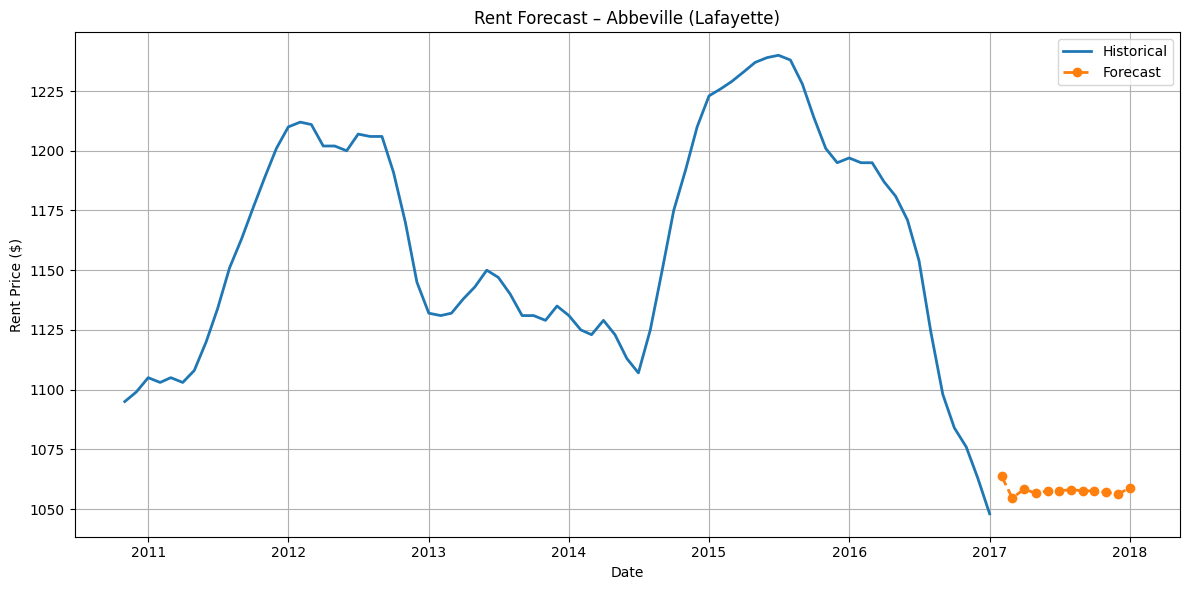

In [26]:
import matplotlib.pyplot as plt
import pandas as pd

# ------------------------------------------
# Select city and metro
# ------------------------------------------
selected_city = "Abbeville"     # example
selected_metro = "Lafayette"   # <-- make sure this matches your data

# ------------------------------------------
# Filter historical data
# ------------------------------------------
historical = df_model.loc[
    (df_model['City'] == selected_city) &
    (df_model['Metro'] == selected_metro)
].copy()

historical['Date'] = pd.to_datetime(
    dict(year=historical['Year'], month=historical['Month'], day=1)
)

# ------------------------------------------
# Filter future prediction data
# ------------------------------------------
future_city = future_df_all.loc[
    (future_df_all['City'] == selected_city) &
    (future_df_all['Metro'] == selected_metro)
].copy()

future_city['Date'] = pd.to_datetime(
    dict(year=future_city['Year'], month=future_city['Month'], day=1)
)

# ------------------------------------------
# Plot historical + forecast
# ------------------------------------------
plt.figure(figsize=(12, 6))

plt.plot(
    historical['Date'],
    historical['RentPrice'],
    label='Historical',
    linewidth=2
)

plt.plot(
    future_city['Date'],
    future_city['Predicted_Rent'],
    linestyle='--',
    marker='o',
    label='Forecast',
    linewidth=2
)

plt.title(f'Rent Forecast – {selected_city} ({selected_metro})')
plt.xlabel('Date')
plt.ylabel('Rent Price ($)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [112]:
future_df_all.to_csv("future_df_all.csv")

In [113]:
df_model.to_csv("df_model.csv")

Linear Regression was selected as the final model because it provides the best balance between predictive performance, interpretability, and robustness under a time-aware evaluation. Although overall R² decreased when incorporating categorical city-level features and forecasting future periods, Linear Regression consistently captured the underlying temporal trend in rental prices and performed competitively against more complex tree-based models. Given the linear nature of rent growth over time and the academic focus on interpretability, Linear Regression was chosen as the final forecasting model.